In [1]:
import numpy as np
import dadi
import dadi.Godambe
import pandas as pd


/home/daron/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fs = dadi.Spectrum.from_file('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/dadi_2D/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LPdom_LBVwil.fs')
ns = (40,40)

Text(0.5, 1.0, 'Orignal data')

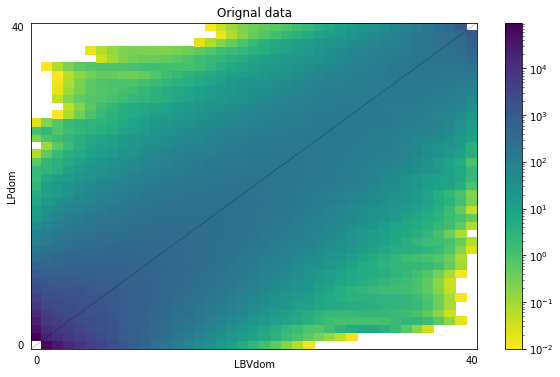

In [3]:
# Plot comparing the multiple versions of our data spectra.
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(10,6))
fig.clear()

ax = fig.add_subplot(1,1,1)
dadi.Plotting.plot_single_2d_sfs(fs, vmin=1e-2, ax=ax)
ax.set_title('Orignal data')


In [4]:
# model
def SCG(params, ns, pts):
    n1,n2 = ns
    nu1, nu2, b1, b2, m12, m21, Ts, Tsc, O = params
   
    """
    Model with split, complete isolation, followed by secondary contact with exponential growth

    nu1: Size of population 1 at split.
    nu2: Size of population 2 at split.
    b1: Population growth coefficient of population 1
    b2: Population growth coefficient of population 2
    m12: Migration from pop 2 to pop 1 (2*Na*m12).
    m21: Migration from pop 1 to pop 2.
    Ts: The scaled time between the split and the secondary contact (in units of 2*Na generations).
    Tsc: The scale time between the secondary contact and present.
    O: The proportion of accurate orientation
    n1,n2: Size of fs to generate.
    pts: Number of points to use in grid for evaluation.
    """
    
    # Define the grid we'll use
    xx = dadi.Numerics.default_grid(pts)

    # phi for the equilibrium ancestral population
    phi = dadi.PhiManip.phi_1D(xx)
    # Now do the divergence event
    phi = dadi.PhiManip.phi_1D_to_2D(xx, phi)
    # We set the population sizes after the split to nu1 and nu2 and the migration rate to zero
    phi = dadi.Integration.two_pops(phi, xx, Ts, nu1, nu2, m12=0, m21=0)
    # We start the population reduction after the split and set the migration rates to m12 and m21
    bnu1_func = lambda t: nu1 * b1**(t/Tsc)
    bnu2_func = lambda t: nu2 * b2**(t/Tsc)
    phi = dadi.Integration.two_pops(phi, xx, Tsc, bnu1_func, bnu2_func, m12=m12, m21=m21)
    ###
    ## Calculate the spectrum
    # Oriented
    fsO = dadi.Spectrum.from_phi(phi, (n1,n2), (xx,xx))
    # Mis-oriented
    fsM = dadi.Numerics.reverse_array(fsO)
    
    # calculate the spectrum.
    fs = O*fsO+(1-O)*fsM
    return fs


In [5]:
pts_l = [50,60,70]
func = SCG
func_ex = dadi.Numerics.make_extrap_log_func(func)

#     nu1, nu2, b1, b2, m12, m21, Ts, Tsc, O = params
popt = [6.078434, 2.054769, 0.1005408, 0.308346, 8.259579, 4.676862, 0.2975986, 0.1729786, 0.9886787]

model = func_ex(popt, ns, pts_l) 

theta = dadi.Inference.optimal_sfs_scaling(model, fs)
print('Optimal value of theta: {0}'.format(theta))

opt = [6.078434, 2.054769, 0.1005408, 0.308346, 8.259579, 4.676862, 0.2975986, 0.1729786, 0.9886787, theta]

Optimal value of theta: 78429.5142581455


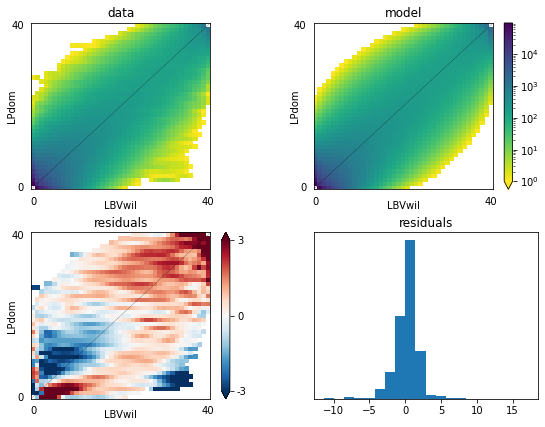

In [6]:
# Plot a comparison of the resulting fs with the data.
import pylab
pylab.figure(figsize=(8,6))
dadi.Plotting.plot_2d_comp_multinom(model, fs, vmin=1, resid_range=3,
                                    pop_ids =('LPdom','LBVwil'), show=False)

In [7]:
# Calculate  Chi^2
scaled_model = model * theta
chi2 = np.sum((scaled_model - fs) ** 2 / scaled_model)
chi2 = np.around(chi2, 2)
print(chi2)

8699.17


In [8]:
# convert parameters in biological units
# https://groups.google.com/g/dadi-user/c/AY_4NoEjsx8/m/D1D2S7-YAAAJ

mu = 3.5e-9 # mutation rate 
L = 39359290 #seq length
g = 0.09 # generation per years

# convert opt in dic
param = ['nu1', 'nu2', 'b1', 'b2', 'm12', 'm21', 'Ts', 'Tsc', 'O', 'theta']
optdic = { param[i] : opt[i] for i in range(0, len(param)) }

bio_param = {}

bio_param['nref'] = optdic['theta']/(4*mu*L)

bio_param['nu1'] = (1/(4*mu*L))*(optdic['theta']*optdic['nu1']) # nref*nu1
bio_param['nu2'] = (1/(4*mu*L))*(optdic['theta']*optdic['nu2'])

bio_param['Ts'] = 2*bio_param['nref']*optdic['Ts']*g
bio_param['Tsc'] = 2*bio_param['nref']*optdic['Tsc']*g

# meaning m12: each generation, number of individuals are migrating from population 2 to population 1.
bio_param['m12']  = optdic['m12']/(2*bio_param['nref'])
bio_param['m21']  = optdic['m21']/(2*bio_param['nref'])

bio_param['nb_m12'] = (bio_param['nref']*optdic['nu1'])*bio_param['m12']
bio_param['nb_m21'] = (bio_param['nref']*optdic['nu2'])*bio_param['m21']


bio_param['b1'] = optdic['b1']
bio_param['b2'] = optdic['b2']

bio_param



{'nref': 142332.5512552718,
 'nu1': 865159.0188567868,
 'nu2': 292460.51401024364,
 'Ts': 7624.434237839483,
 'Tsc': 4431.6873811017285,
 'm12': 2.9015073948848637e-05,
 'm21': 1.6429347885474566e-05,
 'nb_m12': 25.102652909643002,
 'nb_m21': 4.804935527439,
 'b1': 0.1005408,
 'b2': 0.308346}

In [9]:
optdic

{'nu1': 6.078434,
 'nu2': 2.054769,
 'b1': 0.1005408,
 'b2': 0.308346,
 'm12': 8.259579,
 'm21': 4.676862,
 'Ts': 0.2975986,
 'Tsc': 0.1729786,
 'O': 0.9886787,
 'theta': 78429.5142581455}

In [14]:
all_boot = [dadi.Spectrum.from_file('/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/dadi_2D/LPdom_LBVwil_dadi_bootstrap/anopheles-rose.3.unifiedGenotyper.cov14x.passQC.merge.pol.LPdom_LBVwil.fs.boot_{0}'.format(i)) for i in range(100)]

In [15]:
uncerts, GIM = dadi.Godambe.GIM_uncert(func_ex, pts_l, all_boot, popt, fs, multinom=True, return_GIM = True)

ValueError: too many values to unpack (expected 2)

In [18]:
# if non-parametric bootstrapping subsample have been generated, CI is calculated using this cell
# Non-parametric is taking random samples from your data using dadi.Misc.bootstraps_subsample_vcf
print(uncerts)
low = np.subtract(opt, uncerts)
for i in range(len(low)):
    if low[i] < 0:
        low[i] = 0
low = np.around(low, 4)
        
upp = opt + uncerts
upp = np.around(upp, 4)

dic= {'opt': opt, 'ci_low': low, 'ci_upp': upp}
param_ci = pd.DataFrame(dic)
param_ci.index =['nu1', 'nu2', 'b1', 'b2', 'm12', 'm21', 'Ts', 'Tsc', 'O', 'theta']
param_ci

[9.31919869e-01 2.79958976e-01 1.14452344e-02 5.94743686e-02
 1.29838950e+00 8.23823258e-01 4.37477503e-02 7.57683549e-02
 7.40859765e-03 6.75724102e+03]


,opt,ci_low,ci_upp
nu1,6.078434,5.1465,7.0104
nu2,2.054769,1.7748,2.3347
b1,0.100541,0.0891,0.1120
b2,0.308346,0.2489,0.3678
m12,8.259579,6.9612,9.5580
m21,4.676862,3.8530,5.5007
Ts,0.297599,0.2539,0.3413
Tsc,0.172979,0.0972,0.2487
O,0.988679,0.9813,0.9961
theta,78429.514258,71672.2732,85186.7553


In [11]:
# if parametric bootstrap have been generated, calculate CI using this cell
# parametric bootstrapping is using the model to simulate bootstraps of the data, using dadi.Misc.bootstraps_from_dd_chunks

# convert covar 
cov_mat = np.linalg.inv(GIM)
df = pd.DataFrame(cov_mat)
df.columns =['nu1', 'nu2', 'b1', 'b2', 'm12', 'm21', 'Ts', 'Tsc', 'O', 'theta']
df.index =['nu1', 'nu2', 'b1', 'b2', 'm12', 'm21', 'Ts', 'Tsc', 'O', 'theta']

#     nu1, nu2, b1, b2, m12, m21, Ts, Tsc, O, theta
#popt = [6.078434, 2.054769, 0.1005408, 0.308346, 8.259579, 4.676862, 0.2975986, 0.1729786, 0.9886787]
mu = 3.5e-9 # mutation rate 
L = 39359290 #seq length
g = 0.09 # generation per years

# convert opt in dic
param = ['nu1', 'nu2', 'b1', 'b2', 'm12', 'm21', 'Ts', 'Tsc', 'O', 'theta']
optdic = { param[i] : opt[i] for i in range(0, len(param)) }

# get CI
sigma_Nref = (1/(4*mu*L))*df.loc['theta', 'theta']

sigma_nu1 = ((1/(4*mu*L))*optdic['theta']*optdic['nu1'])*np.sqrt(((optdic['theta']/df.loc['theta', 'theta'])**2) + ((optdic['nu1']/df.loc['nu1', 'nu1'])**2) + (2*(df.loc['theta', 'nu1']/(optdic['theta']*optdic['nu1']))))
sigma_nu2 = ((1/(4*mu*L))*optdic['theta']*optdic['nu2'])*np.sqrt(((optdic['theta']/df.loc['theta', 'theta'])**2) + ((optdic['nu2']/df.loc['nu2', 'nu2'])**2) + (2*(df.loc['theta', 'nu2']/(optdic['theta']*optdic['nu2']))))

sigma_m12 = ((2*mu*L)*(optdic['m12']/optdic['theta']))*np.sqrt(((optdic['theta']/df.loc['theta', 'theta'])**2) + ((optdic['m12']/df.loc['m12', 'm12'])**2) - (2*(df.loc['theta', 'm12']/(optdic['theta']*optdic['m12']))))
sigma_m21 = ((2*mu*L)*(optdic['m21']/optdic['theta']))*np.sqrt(((optdic['theta']/df.loc['theta', 'theta'])**2) + ((optdic['m21']/df.loc['m21', 'm21'])**2) - (2*(df.loc['theta', 'm21']/(optdic['theta']*optdic['m21']))))

sigma_Ts = ((1/(4*mu*L))*optdic['theta']*optdic['Ts'])*np.sqrt(((optdic['theta']/df.loc["theta", "theta"])**2) + ((optdic['Ts']/df.loc["Ts", "Ts"])**2) + (2*(df.loc["theta", "Ts"]/(optdic['theta']*optdic['Ts']))))
sigma_Tsc = ((1/(4*mu*L))*optdic['theta']*optdic['Tsc'])*np.sqrt(((optdic['theta']/df.loc["theta", "theta"])**2) + ((optdic['Tsc']/df.loc["Tsc", "Tsc"])**2) + (2*(df.loc["theta", "Tsc"]/(optdic['theta']*optdic['Tsc']))))

#print(str.join('\t', ["sigNref", "signu1", "signu2", "sigm12", "sigm21", "sigTs", "sigTsc"]))
print(str.join('\t', [ str("%.3f" % sigma_Nref), str("%.3f" % sigma_nu1), str("%.3f" % sigma_nu2), str("%.3f" % sigma_m12), str("%.3f" % sigma_m21), str("%.3f" % sigma_Tsc), str("%.3f" % sigma_Ts)]))

uncerts_with_propagation = [sigma_nu1, sigma_nu2, uncerts[2], uncerts[3], sigma_m12, sigma_m21, sigma_Ts, sigma_Tsc, uncerts[8], sigma_Nref]
bio_unit = [bio_param['nu1'], bio_param['nu2'], bio_param['b1'], bio_param['b2'], bio_param['m12'], bio_param['m21'], bio_param['Ts'], bio_param['Tsc'], opt[8], bio_param['nref']]

low = np.subtract(bio_unit, uncerts_with_propagation)
for i in range(len(low)):
    if low[i] < 0:
        low[i] = 0
low = np.around(low, 4)

upp = np.add(opt, uncerts_with_propagation)
upp = np.around(upp, 4)


dic= {'opt': opt, 'bio_unit': bio_unit, 'ci_low': low, 'ci_upp': upp}
param_ci = pd.DataFrame(dic)
param_ci.index =['nu1', 'nu2', 'b1', 'b2', 'm12', 'm21', 'Ts', 'Tsc', 'O', 'Nref']
param_ci

txt_fn = "/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/dadi_2D/wilding.dadi2D.dadiunits.txt"
param_ci.to_csv(txt_fn, sep='\t', index=True,  float_format='%.8f')


82863548.710	6054967.805	7667284.138	0.000	0.000	741840.124	6586498.345


In [269]:
a = ((1/(4*mu*L))*optdic['theta']*optdic['nu1'])*np.sqrt(((optdic['theta']/df.loc['theta', 'theta'])**2) + ((optdic['nu1']/df.loc['nu1', 'nu1'])**2) + (2*(0/(optdic['theta']*optdic['nu1']))))
b = ((1/(4*mu*L))*optdic['theta']*optdic['nu1'])*np.sqrt(((optdic['theta']/df.loc['theta', 'theta'])**2) + ((optdic['nu1']/df.loc['nu1', 'nu1'])**2) + (2*(df.loc['theta', 'nu1']/(optdic['theta']*optdic['nu1']))))

print(a)
print(b)


uncerts[1]*nref






6055228.215104069
6054967.804703096


array([9.31919869e-01, 2.79958976e-01, 1.14452344e-02, 5.94743686e-02,
       1.29838950e+00, 8.23823258e-01, 4.37477503e-02, 7.57683549e-02,
       7.40859765e-03, 6.75724102e+03])

In [213]:
# convert in biological units

mu = 3.5e-9 # mutation rate 
L = 39359290 #seq length
g = 0.09 # generation per years

#bio_param_ci = pd.DataFrame().reindex_like(param_ci)
bio_param_ci = pd.DataFrame(columns=['opt', 'ci_low', 'ci_upp'])

nref = param_ci.loc['theta','opt']/(4*mu*L)
print(nref)

bio_param_ci.loc['nref',:] = param_ci.loc['theta',:]/(4*mu*L)

bio_param_ci.loc['nu1',:] = param_ci.loc['nu1',:]*nref
bio_param_ci.loc['nu2',:] = param_ci.loc['nu2',:]*nref

bio_param_ci.loc['Ts',:] = 2*nref*param_ci.loc['Ts',:]*g
bio_param_ci.loc['Tsc',:] = 2*nref*param_ci.loc['Tsc',:]*g

bio_param_ci.loc['m12',:] = param_ci.loc['m12',:]/(2*nref)
bio_param_ci.loc['m21',:] = param_ci.loc['m21',:]/(2*nref)

bio_param_ci.loc['nb_m12',:] = param_ci.loc['nu1',:]*bio_param_ci.loc['m12',:]
bio_param_ci.loc['nb_m21',:] = param_ci.loc['nu2',:]*bio_param_ci.loc['m21',:]

bio_param_ci.loc['b1',:] = param_ci.loc['b1',:]
bio_param_ci.loc['b2',:] = param_ci.loc['b2',:]

bio_param_ci

txt_fn = "/home/daron/bioInf/wilding/popstructure/popdifferenciation/dadi/dadi_2D/wilding.dadi2D.biounits.txt"
bio_param_ci.to_csv(txt_fn, sep='\t', index=True,  float_format='%.8f')



142332.55125527107
